In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5
import scienceplots

In [2]:
sys.path.append("../../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_2
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D_Learned_Channel_Collapse

In [4]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "NMR_data"
data_save_path_train = data_save_dir / "gauss_train.h5"
data_save_path_test = data_save_dir / "gauss_val.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:]
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test_full = f["X"][:]
    y_test_full = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}")
print(f"y_test shape: {y_test_full.shape}")

X_train shape: (4800, 471, 2)
y_train shape: (4800, 3)
X_test shape: (1200, 471, 2)
y_test shape: (1200, 3)


In [5]:
X_train_full.shape, X_test_full.shape, y_train_full.shape, y_test_full.shape

((4800, 471, 2), (1200, 471, 2), (4800, 3), (1200, 3))

In [18]:
n_train = 1000
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test_full[:n_test]
y_test = y_test_full[:n_test]

seq_len = X_train.shape[1]

Saved figure to figures/generated_gauss_nmr_data_re_samples.pdf


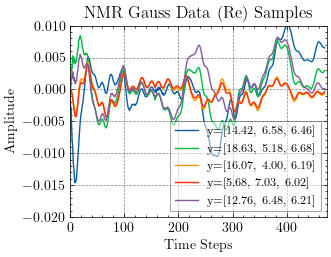

In [7]:
plt.style.use(["science", "grid"])
# plot some data
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 's', 'D', '^', 'v']
for i in range(5):
    l = [f"{yy:.2f}" for yy in y_train[i]]
    l = "y=[" + ", ".join(l) + "]"
    plt.plot(X_train[i,:,0], label=l, color=colors[i % len(colors)])
    # plt.scatter(np.arange(seq_len), X_train[i], color=colors[i % len(colors)], s=10, zorder=5, marker=markers[i % len(markers)])
plt.title("NMR Gauss Data (Re) Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.xlim(0, seq_len + 3)
plt.ylim(-0.02, 0.01)
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)
path = Path("figures")
path.mkdir(parents=True, exist_ok=True)
plt.savefig(path / "generated_gauss_nmr_data_re_samples.pdf", bbox_inches='tight', dpi=300)
print(f"Saved figure to {path / 'generated_gauss_nmr_data_re_samples.pdf'}")
plt.show()


Saved figure to figures/generated_gauss_nmr_data_im_samples.pdf


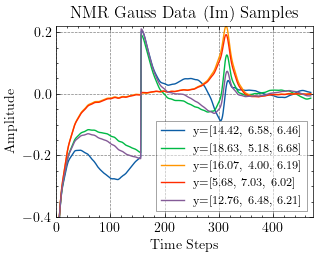

In [8]:
plt.style.use(["science", "grid"])
# plot some data
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 's', 'D', '^', 'v']
for i in range(5):
    l = [f"{yy:.2f}" for yy in y_train[i]]
    l = "y=[" + ", ".join(l) + "]"
    plt.plot(X_train[i,:,1], label=l, color=colors[i % len(colors)])
    # plt.scatter(np.arange(seq_len), X_train[i], color=colors[i % len(colors)], s=10, zorder=5, marker=markers[i % len(markers)])
plt.title("NMR Gauss Data (Im) Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.xlim(0, seq_len + 3)
plt.ylim(-0.4, 0.221)
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)
path = Path("figures")
path.mkdir(parents=True, exist_ok=True)
plt.savefig(path / "generated_gauss_nmr_data_im_samples.pdf", bbox_inches='tight', dpi=300)
print(f"Saved figure to {path / 'generated_gauss_nmr_data_im_samples.pdf'}")
plt.show()

In [19]:
# only take im part of the data and normalize to [0, 1]
# we also fokus on time steps 200:400 to save on compute
idx_start, idx_end = 150, 350
X_train = X_train[:, idx_start:idx_end, 1]
X_val = X_val[:, idx_start:idx_end, 1]
X_test = X_test[:, idx_start:idx_end, 1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val = (X_val - X_val.min()) / (X_val.max() - X_val.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())    

# normalize y_train, y_val, y_test to [0, 1] and save the normalization parameters
y_train_norm_params = {
    "min": y_train.min(axis=0),
    "max": y_train.max(axis=0),
}
y_val_norm_params = {
    "min": y_val.min(axis=0),
    "max": y_val.max(axis=0),
}
y_test_norm_params = {
    "min": y_test.min(axis=0),
    "max": y_test.max(axis=0),
}
y_train = (y_train - y_train.min(axis=0)) / (y_train.max(axis=0) - y_train.min(axis=0))
y_val = (y_val - y_val.min(axis=0)) / (y_val.max(axis=0) - y_val.min(axis=0))
y_test = (y_test - y_test.min(axis=0)) / (y_test.max(axis=0) - y_test.min(axis=0))

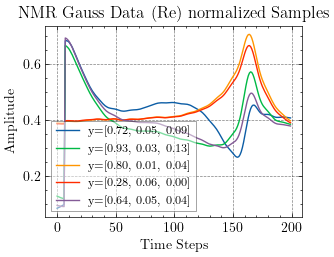

In [20]:
plt.style.use(["science", "grid"])
# plot some data
textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 's', 'D', '^', 'v']
for i in range(5):
    l = [f"{yy:.2f}" for yy in y_train[i]]
    l = "y=[" + ", ".join(l) + "]"
    plt.plot(X_train[i], label=l, color=colors[i % len(colors)])
    # plt.scatter(np.arange(seq_len), X_train[i], color=colors[i % len(colors)], s=10, zorder=5, marker=markers[i % len(markers)])
plt.title("NMR Gauss Data (Re) normalized Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
# plt.ylim(-0.4, 0.221)
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)

In [26]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (kernel_size := 11),  # =1D kernel size
    "input_length": seq_len,
    "stride": 7,  # stride for the convolution
    "output_dim": 3,  # output dimension of the final FC NN
    "hidden_layers_dims": [100,50],
    "dropout": 0.4,  # dropout rate
    "conv1_channels": 25,
}

CNN_classical = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
# todo: use a new classical CNN similar to the quantum version

In [27]:
# change model to float64
CNN_classical = CNN_classical.double()

# number of trainable parameters
n_params = sum(p.numel() for p in CNN_classical.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 8429


In [28]:
x_val = torch.tensor(X_val, dtype=torch.float64).reshape(-1, 1, seq_len)
y_val = torch.tensor(y_val, dtype=torch.float64)

# train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
batch_size = 64
epochs = 10_000
loss_hist = []
loss_hist_val = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.001, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
CNN_classical.to(device)
for epoch in range(epochs):
    CNN_classical.train()
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    # for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(-1, 1, seq_len).to(device)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1).to(device)
        batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted, y_batch)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epoch_loss = np.mean(epoch_losses)
    loss_hist.append(epoch_loss)

    # validation
    CNN_classical.eval()
    with torch.no_grad():
        val_out = CNN_classical(x_val.to(device))  # (batch_size, 1, seq_len)
        val_loss = loss_fn(val_out.squeeze(1), y_val.to(device))
        loss_hist_val.append(val_loss.item())
        if epoch % 100 == 0:
            tqdm.write(f"Epoch {epoch+1} train RMSE: {np.sqrt(epoch_loss):.4f}, "
                       f"val RMSE: {np.sqrt(val_loss.item()):.4f}")

loss_hist = np.array(loss_hist)
loss_hist_val = np.array(loss_hist_val)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

/tmp/ipykernel_25814/2864723014.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float64)


Epoch 1 train RMSE: 0.2754, val RMSE: 0.2135
Epoch 101 train RMSE: 0.1736, val RMSE: 0.1717
Epoch 201 train RMSE: 0.1671, val RMSE: 0.1727
Epoch 301 train RMSE: 0.1515, val RMSE: 0.1629
Epoch 401 train RMSE: 0.1221, val RMSE: 0.1765
Epoch 501 train RMSE: 0.1090, val RMSE: 0.1589
Epoch 601 train RMSE: 0.1082, val RMSE: 0.2026
Epoch 701 train RMSE: 0.1071, val RMSE: 0.1532
Epoch 801 train RMSE: 0.1100, val RMSE: 0.1320
Epoch 901 train RMSE: 0.1051, val RMSE: 0.1642
Epoch 1001 train RMSE: 0.1096, val RMSE: 0.1720
Epoch 1101 train RMSE: 0.1077, val RMSE: 0.1279
Epoch 1201 train RMSE: 0.1029, val RMSE: 0.1416
Epoch 1301 train RMSE: 0.1011, val RMSE: 0.1539
Epoch 1401 train RMSE: 0.1008, val RMSE: 0.1513
Epoch 1501 train RMSE: 0.1004, val RMSE: 0.1583
Epoch 1601 train RMSE: 0.0995, val RMSE: 0.1473
Epoch 1701 train RMSE: 0.0940, val RMSE: 0.1372
Epoch 1801 train RMSE: 0.0960, val RMSE: 0.1646
Epoch 1901 train RMSE: 0.0971, val RMSE: 0.1484
Epoch 2001 train RMSE: 0.0948, val RMSE: 0.1607
Epoc

In [29]:
# test the model
CNN_classical.eval()
y_pred_test = []
CNN_classical.to("cpu")
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64).reshape(-1, 1, seq_len)
    pred = CNN_classical(x_test)
    y_pred_test.append(pred)
y_pred_test = torch.stack(y_pred_test).squeeze(1)  # (n_test, seq_len)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)  # already
y_test = torch.tensor(y_test, dtype=torch.float64)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")

Test loss MSE: 0.009646197509302158
RMSE: 0.09821505744692184


/tmp/ipykernel_25814/1311282766.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)  # already


In [30]:
y_pred_test.shape

torch.Size([500, 3])

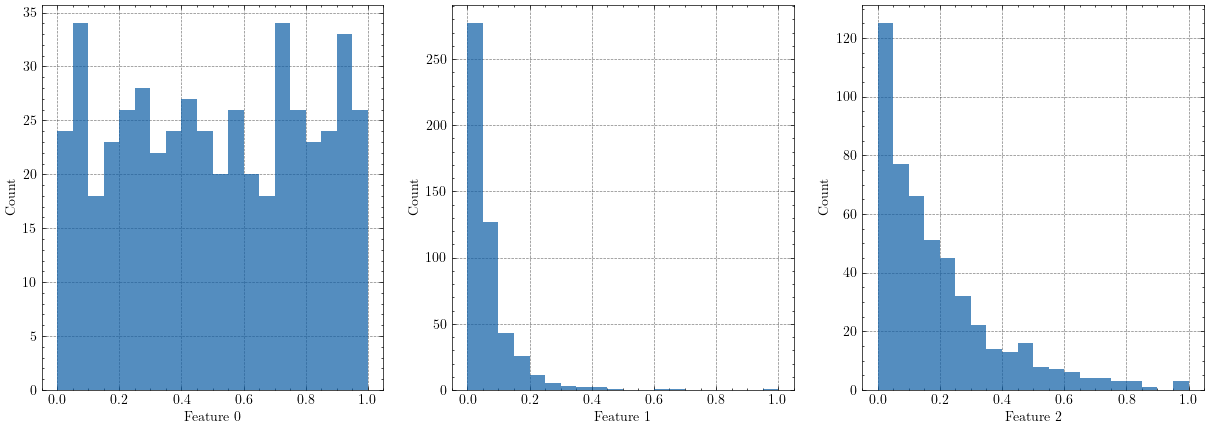

In [31]:
# histogram of test values
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(y_test.numpy()[:, 0], bins=20, alpha=0.7)
axs[0].set_xlabel("Feature 0")
axs[0].set_ylabel("Count")

axs[1].hist(y_test.numpy()[:, 1], bins=20, alpha=0.7)
axs[1].set_xlabel("Feature 1")
axs[1].set_ylabel("Count")

axs[2].hist(y_test.numpy()[:, 2], bins=20, alpha=0.7)
axs[2].set_xlabel("Feature 2")
axs[2].set_ylabel("Count")

plt.show()

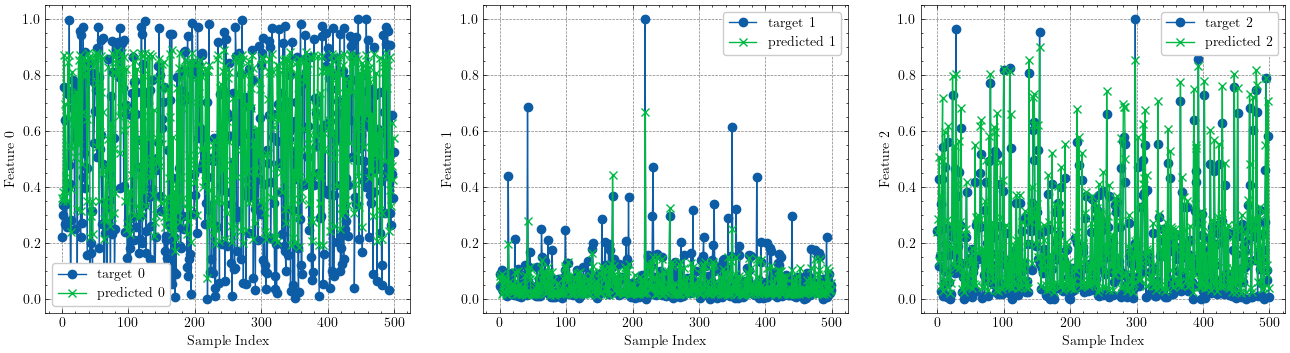

In [32]:
# plot the results
fig, axs = plt.subplots(1,3, figsize=(16, 4))
axs[0].plot(y_test.numpy()[:, 0], label="target 0", marker='o')
axs[0].plot(y_pred_test.numpy()[:, 0], label="predicted 0", marker='x')
axs[0].set_xlabel("Sample Index")
axs[0].set_ylabel("Feature 0")
axs[0].legend()
axs[1].plot(y_test.numpy()[:, 1], label="target 1", marker='o')
axs[1].plot(y_pred_test.numpy()[:, 1], label="predicted 1", marker='x')
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("Feature 1")
axs[1].legend()
axs[2].plot(y_test.numpy()[:, 2], label="target 2", marker='o')
axs[2].plot(y_pred_test.numpy()[:, 2], label="predicted 2", marker='x')
axs[2].set_xlabel("Sample Index")
axs[2].set_ylabel("Feature 2")
axs[2].legend()
plt.show()

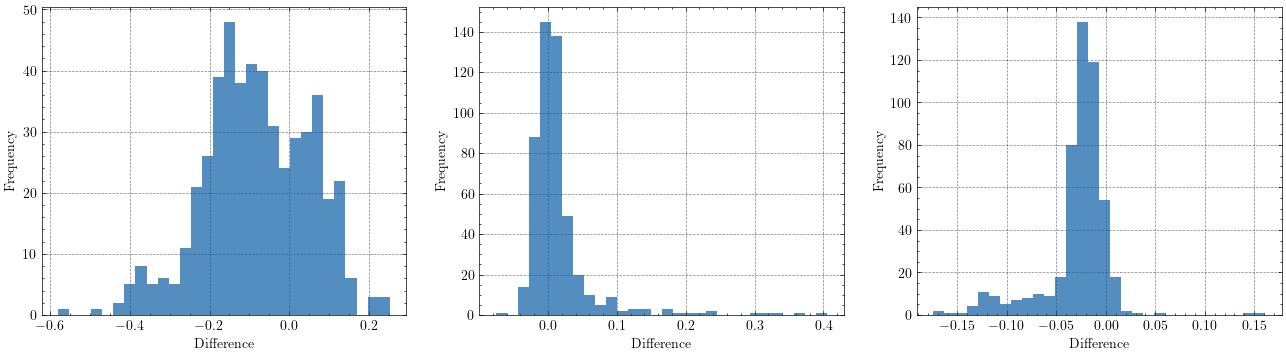

In [33]:
diffs = y_test - y_pred_test
# histogram of the differences
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].hist(diffs[:,0].numpy(), bins=30, alpha=0.7)
axs[0].set_xlabel("Difference")
axs[0].set_ylabel("Frequency")

axs[1].hist(diffs[:,1].numpy(), bins=30, alpha=0.7)
axs[1].set_xlabel("Difference")
axs[1].set_ylabel("Frequency")

axs[2].hist(diffs[:,2].numpy(), bins=30, alpha=0.7)
axs[2].set_xlabel("Difference")
axs[2].set_ylabel("Frequency")

plt.show() 

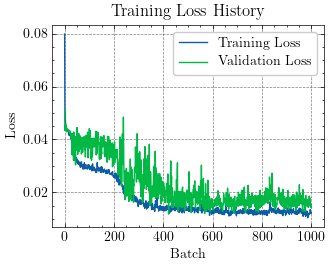

In [36]:
plt.plot(loss_hist, label="Training Loss")
plt.plot(loss_hist_val, label="Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [124]:
import pickle

# number of learned parameters, i.e. with require_grad=True
CNN_classical.train()
# number of parameters
n_params = sum(v.numel() for p, v in CNN_classical.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/Classical_CNN__dist_grad_false_stride_3_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

AttributeError: 'generator' object has no attribute 'items'